# Importing Libraries

In [1]:
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from collections import defaultdict
%matplotlib inline
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.snowball import SnowballStemmer
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
nltk.download('stopwords')
nltk.download('punkt')
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn import metrics
from sklearn.metrics import accuracy_score
from sklearn.svm import SVC
from sklearn.svm import LinearSVC
from sklearn.metrics import confusion_matrix, plot_confusion_matrix
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer

import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter('ignore')


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


# Preprocessing

In [2]:
train = pd.read_csv('/content/drive/MyDrive/train.csv')
test = pd.read_csv('/content/drive/MyDrive/test.csv')
train.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [3]:
train = train.drop(['keyword','location'], axis = 1)
test = test.drop(['keyword','location'], axis = 1)
train.head()

,id,text,target
0,1,Our Deeds are the Reason of this #earthquake M...,1
1,4,Forest fire near La Ronge Sask. Canada,1
2,5,All residents asked to 'shelter in place' are ...,1
3,6,"13,000 people receive #wildfires evacuation or...",1
4,7,Just got sent this photo from Ruby #Alaska as ...,1


In [4]:
# Checking Shape of Train and Test sets:
print("Shape of Train set:", train.shape)
print("Shape of Test set:", test.shape)

Shape of Train set: (7613, 3)
Shape of Test set: (3263, 2)


In [5]:
# Removing duplicates of Train set. There are few duplicates in Test set as well,
# however, duplicates of Test set can'b be removed because the final test with target has to be uploaded as a submission file

train = train.drop_duplicates(subset=['text'], keep='last')
print("Shape of Train set after removing duplicates:", train.shape)

Shape of Train set after removing duplicates: (7503, 3)


In [6]:
train[train['text'].map(lambda x: x.isascii())]
test[test['text'].map(lambda x: x.isascii())]

# Cleaning Tweets
def clean_tweets(text):
    text = re.sub(r'@[A-Za-z0-9_]+','',text)    # Removing @mentions
    text = re.sub(r'#','',text)                 # Removing #tag symbol
    text = re.sub(r'RT[\s]+',' ',text)          # Remvoing RT
    text = re.sub(r'\n','',text) 
    text = re.sub(r',','',text) 
    text = re.sub(r'.[.]+','',text) 
    text = re.sub(r'\w+:\/\/\S+','',text) 
    text = re.sub(r'https?:\/\/\S+','',text)    # Removing hyperlinks
    text = re.sub(r'/',' ',text)
    text = re.sub(r'-',' ',text)
    text = re.sub(r'_',' ',text)
    text = re.sub(r'!','',text)
    text = re.sub(r':',' ',text)
    text = re.sub(r'$','',text)
    text = re.sub(r'%','',text)
    text = re.sub(r'^','',text)
    text = re.sub(r'&','',text)
    text = re.sub(r'=',' ',text)
    text = re.sub(r' +',' ',text)               # Removing extra whitespaces

    return text

# Removing Emojis
def clean_emoji(inputString):
    return inputString.encode('ascii', 'ignore').decode('ascii')

train['text'] = train['text'].apply(clean_tweets)    # Applying function to clean tweets
train['text'] = train['text'].apply(clean_emoji)     # Applying function to remove emojis
train['text'] = train.text.str.lower()               # Making all texts to lower case
train['text'] = train['text'].str.strip()            # Removing leading and trailing whitespaces

test['text'] = test['text'].apply(clean_tweets)      # Applying function to clean tweets
test['text'] = test['text'].apply(clean_emoji)       # Applying function to remove emojis
test['text'] = test.text.str.lower()                 # Making all texts to lower case
test['text'] = test['text'].str.strip()              # Removing leading and trailing whitespaces
#pd.set_option('display.max_rows', None)
pd.set_option('display.max_colwidth', -1)


Labels are as follows:¶

'target' -> This denotes whether a tweet is about a real disaster (1) or not (0)

In [7]:
train['target'].value_counts()

0    4307
1    3196
Name: target, dtype: int64

# Setups:

Each of our classification models (SVM, Naive Bayes, Logistic Regression, K Nearest Neighbours, Ada Boost, Gradient boosting and Random Forest) were
tested on the following setups:

1. **Setup 1: Removing Punctuation:** All the models are trained and tested after removing punctuations from the corpus.
2. **Setup 2: Removing Stop-words:** All the models are trained and tested after removing stop-words from the corpus.
3. **Setup 3: Removing Numbers:** All the models are trained and tested after removing numbers from the corpus.
4. **Setup 4: Removing Repeating Characters:** All the models are trained and tested after removing repeating characters.
5. **Setup 5: Stemming and Lemmatization:** All the models are trained and tested after applying stemming and lemmatization.
6. **Setup 6: Setup 1–5:** All the models are trained and tested after removing punctuation, stop-words, numbers, repeating words, stemming and lemmatization.
7. **Setup 7: Keeping all above features:** All the models are trained and tested without eliminating any of the above special features.

# Models:
### These models with hyperparameters will be used by all setups, to find the best setup and best model:

In [8]:
# making a dictionary with four models with some parameters:

model_params = {
    
    'SVC' :{
        'model' : SVC(),
        'params' : {
            'C': [0.1, 1, 10], 'gamma': [1, 0.1, 0.01], 'kernel': ['rbf','linear','poly','sigmoid']
        }
    },
    
    'MultinomialNB' :{
        'model' : MultinomialNB(),
        'params' : {
            'alpha' : np.linspace(0.5, 1.5, 6), 'fit_prior' : [True, False]
        }
    },
    
    'logistics_regression' :{
        'model' : LogisticRegression(solver = 'lbfgs', multi_class = 'auto'),
        'params' : {
            'C' : [0.1, 1, 20, 40, 60, 80, 100], 'solver' : ['lbfgs', 'liblinear']
        }
    },
    'K_Nearest_Neighbors' :{
        'model' : KNeighborsClassifier(),
        'params' : {
            'n_neighbors' : [5, 10, 20, 50, 80, 100, 200], 'weights' : ['uniform', 'distance']
        }
    },
    
    'random_forest' :{
        'model' : RandomForestClassifier(),
        'params' : {
            'n_estimators' : [50,100,150], 
            'max_depth':[2,3,None], 'criterion':['gini','entropy']
        }
    },
    'AdaBoost' :{
        'model' : AdaBoostClassifier(),
        'params' : {
            'n_estimators' : [50,100,150], 'learning_rate' : [0.5,1,1.5]
        }
    }
    #'Gradient_Boosting' :{ 'model' : GradientBoostingClassifier(),'params' : {'n_estimators' : [50,100,150], 'criterion':['friedman_mse', 'squared_error', 'mae']}}
}

## Setup 1: Models after removing Punctuations:

In [9]:
# Creating a df that is copy of the train set.
df = train.copy()

### Removing Punctuations:

In [10]:
import string
string.punctuation

'!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

In [11]:
punctuations_list = string.punctuation
def cleaning_punctuations(text):
    translator = str.maketrans('', '', punctuations_list)
    return text.translate(translator)

df['text'] = df['text'].apply(lambda x: cleaning_punctuations(x))

### Splitting data into Train and Test :

In [12]:
# Splitting data into Train and Test sets:
X = df['text']
y = df['target']
X_train, X_test, y_train, y_test =  train_test_split(X, y, test_size = 0.2, random_state = 3)

### Transforming dataset using TF-IDF Vectorizer:

In [13]:
# Extracting features using TF-IDF (1,2) - unigrams and bigrams
vectoriser = TfidfVectorizer(ngram_range=(1,2), max_features=500000)
vectoriser.fit(X_train)
print('No. of feature_words: ', len(vectoriser.get_feature_names()))

# Transforming the data using TD-IDF Vectorizer
X_train = vectoriser.transform(X_train)
X_test  = vectoriser.transform(X_test)

No. of feature_words:  62381


### Results:

In [14]:
%%time

# implemented GridSearchCV for four models using a loop and a previously created dictionary
# in the created variable 'scores', results are stored for each model such as: model, best_score and best_params.


scores = []

for model_name, mp in model_params.items():
    clf = GridSearchCV(mp['model'], mp['params'], cv=5, n_jobs=-1, verbose=1) # Using Cross Validation of 5 and n_jobs=-1 for fast training by using all the processors
    print(mp['model'])
    print('\nTraining the model...')
    best_model = clf.fit(X_train, y_train)                      # Training the model
    clf_pred = best_model.predict(X_test)                       # Predicting the results
    print(confusion_matrix(y_test,clf_pred))                    # Printing Confusion Matrix
    print(metrics.classification_report(y_test, clf_pred))      # Printing Classification Report
    scores.append({                                             # Appending results to 'scores' list
        'model' : model_name,
        'best_score' : best_model.score(X_test, y_test),
        'best_params' : clf.best_params_
    })
    print('\nScore is appended.\n')
    
# Creating data frame with model, best scores and best params:
res1 = pd.DataFrame(scores, columns=['model', 'best_score', 'best_params'])

SVC()

Training the model...
Fitting 5 folds for each of 36 candidates, totalling 180 fits
[[735 108]
 [185 473]]
              precision    recall  f1-score   support

           0       0.80      0.87      0.83       843
           1       0.81      0.72      0.76       658

    accuracy                           0.80      1501
   macro avg       0.81      0.80      0.80      1501
weighted avg       0.81      0.80      0.80      1501


Score is appended.

MultinomialNB()

Training the model...
Fitting 5 folds for each of 12 candidates, totalling 60 fits
[[778  65]
 [237 421]]
              precision    recall  f1-score   support

           0       0.77      0.92      0.84       843
           1       0.87      0.64      0.74       658

    accuracy                           0.80      1501
   macro avg       0.82      0.78      0.79      1501
weighted avg       0.81      0.80      0.79      1501


Score is appended.

LogisticRegression()

Training the model...
Fitting 5 folds for eac

In [15]:
res1

,model,best_score,best_params
0,SVC,0.804797,"{'C': 1, 'gamma': 1, 'kernel': 'linear'}"
1,MultinomialNB,0.798801,"{'alpha': 0.5, 'fit_prior': True}"
2,logistics_regression,0.790806,"{'C': 20, 'solver': 'liblinear'}"
3,K_Nearest_Neighbors,0.784810,"{'n_neighbors': 50, 'weights': 'distance'}"
4,random_forest,0.780147,"{'criterion': 'gini', 'max_depth': None, 'n_estimators': 100}"
5,AdaBoost,0.742172,"{'learning_rate': 0.5, 'n_estimators': 150}"


## Setup 2: Models after removing Stop-words:

In [16]:
# Creating a df that is copy of the train set.
df = train.copy()

### Removing Stop-words:

In [17]:
sw = stopwords.words('english')
df['text'] = df['text'].apply(lambda x: ' '.join([word for word in x.split() if word not in (sw)]))

### Splitting data into Train and Test :

In [18]:
# Splitting data into Train and Test sets:
X = df['text']
y = df['target']
X_train, X_test, y_train, y_test =  train_test_split(X, y, test_size = 0.2, random_state = 3)

### Transforming dataset using TF-IDF Vectorizer:

In [19]:
# Extracting features using TF-IDF (1,2) - unigrams and bigrams
vectoriser = TfidfVectorizer(ngram_range=(1,2), max_features=500000)
vectoriser.fit(X_train)
print('No. of feature_words: ', len(vectoriser.get_feature_names()))

# Transforming the data using TD-IDF Vectorizer
X_train = vectoriser.transform(X_train)
X_test  = vectoriser.transform(X_test)

No. of feature_words:  51017


### Results:

In [20]:
%%time

# implemented GridSearchCV for four models using a loop and a previously created dictionary
# in the created variable 'scores', results are stored for each model such as: model, best_score and best_params.


scores = []

for model_name, mp in model_params.items():
    clf = GridSearchCV(mp['model'], mp['params'], cv=5, n_jobs=-1, verbose=1) # Using Cross Validation of 5 and n_jobs=-1 for fast training by using all the processors
    print(mp['model'])
    print('\nTraining the model...')
    best_model = clf.fit(X_train, y_train)                      # Training the model
    clf_pred = best_model.predict(X_test)                       # Predicting the results
    print(confusion_matrix(y_test,clf_pred))                    # Printing Confusion Matrix
    print(metrics.classification_report(y_test, clf_pred))      # Printing Classification Report
    scores.append({                                             # Appending results to 'scores' list
        'model' : model_name,
        'best_score' : best_model.score(X_test, y_test),
        'best_params' : clf.best_params_
    })
    print('\nScore is appended.\n')
    
# Creating data frame with model, best scores and best params:
res2 = pd.DataFrame(scores, columns=['model', 'best_score', 'best_params'])

SVC()

Training the model...
Fitting 5 folds for each of 36 candidates, totalling 180 fits
[[728 115]
 [182 476]]
              precision    recall  f1-score   support

           0       0.80      0.86      0.83       843
           1       0.81      0.72      0.76       658

    accuracy                           0.80      1501
   macro avg       0.80      0.79      0.80      1501
weighted avg       0.80      0.80      0.80      1501


Score is appended.

MultinomialNB()

Training the model...
Fitting 5 folds for each of 12 candidates, totalling 60 fits
[[767  76]
 [220 438]]
              precision    recall  f1-score   support

           0       0.78      0.91      0.84       843
           1       0.85      0.67      0.75       658

    accuracy                           0.80      1501
   macro avg       0.81      0.79      0.79      1501
weighted avg       0.81      0.80      0.80      1501


Score is appended.

LogisticRegression()

Training the model...
Fitting 5 folds for eac

In [21]:
res2

,model,best_score,best_params
0,SVC,0.802132,"{'C': 1, 'gamma': 1, 'kernel': 'linear'}"
1,MultinomialNB,0.802798,"{'alpha': 0.5, 'fit_prior': True}"
2,logistics_regression,0.784810,"{'C': 40, 'solver': 'lbfgs'}"
3,K_Nearest_Neighbors,0.782145,"{'n_neighbors': 100, 'weights': 'distance'}"
4,random_forest,0.762159,"{'criterion': 'gini', 'max_depth': None, 'n_estimators': 50}"
5,AdaBoost,0.756163,"{'learning_rate': 0.5, 'n_estimators': 150}"


## Setup 3: Models after removing numbers:

In [22]:
# Creating a df that is copy of the train set.
df = train.copy()

### Removing numbers:

In [23]:
def cleaning_numbers(text):
    return re.sub('[0-9]+', '', text)

df['text'] = df['text'].apply(lambda text: cleaning_numbers(text))

### Splitting data into Train and Test :

In [24]:
# Splitting data into Train and Test sets:
X = df['text']
y = df['target']
X_train, X_test, y_train, y_test =  train_test_split(X, y, test_size = 0.2, random_state = 3)

### Transforming dataset using TF-IDF Vectorizer:

In [25]:
# Extracting features using TF-IDF (1,2) - unigrams and bigrams
vectoriser = TfidfVectorizer(ngram_range=(1,2), max_features=500000)
vectoriser.fit(X_train)
print('No. of feature_words: ', len(vectoriser.get_feature_names()))

# Transforming the data using TD-IDF Vectorizer
X_train = vectoriser.transform(X_train)
X_test  = vectoriser.transform(X_test)

No. of feature_words:  60344


### Results:

In [26]:
%%time

# implemented GridSearchCV for four models using a loop and a previously created dictionary
# in the created variable 'scores', results are stored for each model such as: model, best_score and best_params.


scores = []

for model_name, mp in model_params.items():
    clf = GridSearchCV(mp['model'], mp['params'], cv=5, n_jobs=-1, verbose=1) # Using Cross Validation of 5 and n_jobs=-1 for fast training by using all the processors
    print(mp['model'])
    print('\nTraining the model...')
    best_model = clf.fit(X_train, y_train)                      # Training the model
    clf_pred = best_model.predict(X_test)                       # Predicting the results
    print(confusion_matrix(y_test,clf_pred))                    # Printing Confusion Matrix
    print(metrics.classification_report(y_test, clf_pred))      # Printing Classification Report
    scores.append({                                             # Appending results to 'scores' list
        'model' : model_name,
        'best_score' : best_model.score(X_test, y_test),
        'best_params' : clf.best_params_
    })
    print('\nScore is appended.\n')
    
# Creating data frame with model, best scores and best params:
res3 = pd.DataFrame(scores, columns=['model', 'best_score', 'best_params'])

SVC()

Training the model...
Fitting 5 folds for each of 36 candidates, totalling 180 fits
[[732 111]
 [187 471]]
              precision    recall  f1-score   support

           0       0.80      0.87      0.83       843
           1       0.81      0.72      0.76       658

    accuracy                           0.80      1501
   macro avg       0.80      0.79      0.80      1501
weighted avg       0.80      0.80      0.80      1501


Score is appended.

MultinomialNB()

Training the model...
Fitting 5 folds for each of 12 candidates, totalling 60 fits
[[772  71]
 [236 422]]
              precision    recall  f1-score   support

           0       0.77      0.92      0.83       843
           1       0.86      0.64      0.73       658

    accuracy                           0.80      1501
   macro avg       0.81      0.78      0.78      1501
weighted avg       0.81      0.80      0.79      1501


Score is appended.

LogisticRegression()

Training the model...
Fitting 5 folds for eac

In [27]:
res3

,model,best_score,best_params
0,SVC,0.801466,"{'C': 1, 'gamma': 1, 'kernel': 'linear'}"
1,MultinomialNB,0.795470,"{'alpha': 0.5, 'fit_prior': True}"
2,logistics_regression,0.787475,"{'C': 40, 'solver': 'lbfgs'}"
3,K_Nearest_Neighbors,0.783478,"{'n_neighbors': 80, 'weights': 'distance'}"
4,random_forest,0.775483,"{'criterion': 'gini', 'max_depth': None, 'n_estimators': 50}"
5,AdaBoost,0.742172,"{'learning_rate': 0.5, 'n_estimators': 150}"


## Setup 4: Models after removing repeating characters:

In [28]:
# Creating a df that is copy of the train set.
df = train.copy()

### Removing repeating characteres:

In [29]:
tokens = (word_tokenize(i) for i in df.text)
df['text'] = df['text'].apply(nltk.word_tokenize)

pattern = re.compile(r'(.)\1*')

def reduce_sequence_word(word):
    return ''.join([match.group()[:2] if len(match.group()) > 2 else match.group() for match in pattern.finditer(word)])

def reduce_sequence_tweet(tweet):
    return [reduce_sequence_word(word) for word in tweet]

df.text = df.text.apply(lambda tweet: reduce_sequence_tweet(tweet))

### Splitting data into Train and Test :

In [30]:
# Splitting data into Train and Test sets:
X = df['text'].astype(str)
y = df['target'].astype(str)
X_train, X_test, y_train, y_test =  train_test_split(X, y, test_size = 0.2, random_state = 3)

### Transforming dataset using TF-IDF Vectorizer:

In [31]:
# Extracting features using TF-IDF (1,2) - unigrams and bigrams
vectoriser = TfidfVectorizer(ngram_range=(1,2), max_features=500000)
vectoriser.fit(X_train)
print('No. of feature_words: ', len(vectoriser.get_feature_names()))

# Transforming the data using TD-IDF Vectorizer
X_train = vectoriser.transform(X_train)
X_test  = vectoriser.transform(X_test)

No. of feature_words:  62005


### Results:

In [32]:
%%time

# implemented GridSearchCV for four models using a loop and a previously created dictionary
# in the created variable 'scores', results are stored for each model such as: model, best_score and best_params.


scores = []

for model_name, mp in model_params.items():
    clf = GridSearchCV(mp['model'], mp['params'], cv=5, n_jobs=-1, verbose=1) # Using Cross Validation of 5 and n_jobs=-1 for fast training by using all the processors
    print(mp['model'])
    print('\nTraining the model...')
    best_model = clf.fit(X_train, y_train)                      # Training the model
    clf_pred = best_model.predict(X_test)                       # Predicting the results
    print(confusion_matrix(y_test,clf_pred))                    # Printing Confusion Matrix
    print(metrics.classification_report(y_test, clf_pred))      # Printing Classification Report
    scores.append({                                             # Appending results to 'scores' list
        'model' : model_name,
        'best_score' : best_model.score(X_test, y_test),
        'best_params' : clf.best_params_
    })
    print('\nScore is appended.\n')
    
# Creating data frame with model, best scores and best params:
res4 = pd.DataFrame(scores, columns=['model', 'best_score', 'best_params'])

SVC()

Training the model...
Fitting 5 folds for each of 36 candidates, totalling 180 fits
[[732 111]
 [187 471]]
              precision    recall  f1-score   support

           0       0.80      0.87      0.83       843
           1       0.81      0.72      0.76       658

    accuracy                           0.80      1501
   macro avg       0.80      0.79      0.80      1501
weighted avg       0.80      0.80      0.80      1501


Score is appended.

MultinomialNB()

Training the model...
Fitting 5 folds for each of 12 candidates, totalling 60 fits
[[779  64]
 [233 425]]
              precision    recall  f1-score   support

           0       0.77      0.92      0.84       843
           1       0.87      0.65      0.74       658

    accuracy                           0.80      1501
   macro avg       0.82      0.78      0.79      1501
weighted avg       0.81      0.80      0.80      1501


Score is appended.

LogisticRegression()

Training the model...
Fitting 5 folds for eac

In [33]:
res4

,model,best_score,best_params
0,SVC,0.801466,"{'C': 1, 'gamma': 1, 'kernel': 'linear'}"
1,MultinomialNB,0.802132,"{'alpha': 0.5, 'fit_prior': True}"
2,logistics_regression,0.791472,"{'C': 80, 'solver': 'lbfgs'}"
3,K_Nearest_Neighbors,0.784144,"{'n_neighbors': 80, 'weights': 'distance'}"
4,random_forest,0.768821,"{'criterion': 'entropy', 'max_depth': None, 'n_estimators': 150}"
5,AdaBoost,0.744837,"{'learning_rate': 0.5, 'n_estimators': 150}"


## Setup 5: Applying Stemming and Lemmatization:

In [34]:
# Creating a df that is copy of the train set.
df = train.copy()

### Applying Stemming: 

In [35]:
# Tokenizing tweets:
tokens = (word_tokenize(i) for i in df.text)
df['text'] = df['text'].apply(nltk.word_tokenize)

stemm = SnowballStemmer('english')
df['text'] = df['text'].apply(lambda x: [stemm.stem(y) for y in x])

### Splitting data into Train and Test :

In [36]:
# Splitting data into Train and Test sets:
X = df['text'].astype(str)
y = df['target'].astype(str)
X_train, X_test, y_train, y_test =  train_test_split(X, y, test_size = 0.2, random_state = 3)

### Transforming dataset using TF-IDF Vectorizer:

In [37]:
# Extracting features using TF-IDF (1,2) - unigrams and bigrams
vectoriser = TfidfVectorizer(ngram_range=(1,2), max_features=500000)
vectoriser.fit(X_train)
print('No. of feature_words: ', len(vectoriser.get_feature_names()))

# Transforming the data using TD-IDF Vectorizer
X_train = vectoriser.transform(X_train)
X_test  = vectoriser.transform(X_test)

No. of feature_words:  57871


### Results:

In [38]:
%%time

# implemented GridSearchCV for four models using a loop and a previously created dictionary
# in the created variable 'scores', results are stored for each model such as: model, best_score and best_params.


scores = []

for model_name, mp in model_params.items():
    clf = GridSearchCV(mp['model'], mp['params'], cv=5, n_jobs=-1, verbose=1) # Using Cross Validation of 5 and n_jobs=-1 for fast training by using all the processors
    print(mp['model'])
    print('\nTraining the model...')
    best_model = clf.fit(X_train, y_train)                      # Training the model
    clf_pred = best_model.predict(X_test)                       # Predicting the results
    print(confusion_matrix(y_test,clf_pred))                    # Printing Confusion Matrix
    print(metrics.classification_report(y_test, clf_pred))      # Printing Classification Report
    scores.append({                                             # Appending results to 'scores' list
        'model' : model_name,
        'best_score' : best_model.score(X_test, y_test),
        'best_params' : clf.best_params_
    })
    print('\nScore is appended.\n')
    
# Creating data frame with model, best scores and best params:
res5 = pd.DataFrame(scores, columns=['model', 'best_score', 'best_params'])

SVC()

Training the model...
Fitting 5 folds for each of 36 candidates, totalling 180 fits
[[709 134]
 [184 474]]
              precision    recall  f1-score   support

           0       0.79      0.84      0.82       843
           1       0.78      0.72      0.75       658

    accuracy                           0.79      1501
   macro avg       0.79      0.78      0.78      1501
weighted avg       0.79      0.79      0.79      1501


Score is appended.

MultinomialNB()

Training the model...
Fitting 5 folds for each of 12 candidates, totalling 60 fits
[[774  69]
 [232 426]]
              precision    recall  f1-score   support

           0       0.77      0.92      0.84       843
           1       0.86      0.65      0.74       658

    accuracy                           0.80      1501
   macro avg       0.81      0.78      0.79      1501
weighted avg       0.81      0.80      0.79      1501


Score is appended.

LogisticRegression()

Training the model...
Fitting 5 folds for eac

In [39]:
res5

,model,best_score,best_params
0,SVC,0.788141,"{'C': 10, 'gamma': 0.1, 'kernel': 'sigmoid'}"
1,MultinomialNB,0.799467,"{'alpha': 0.5, 'fit_prior': True}"
2,logistics_regression,0.782811,"{'C': 20, 'solver': 'lbfgs'}"
3,K_Nearest_Neighbors,0.790140,"{'n_neighbors': 80, 'weights': 'distance'}"
4,random_forest,0.774817,"{'criterion': 'gini', 'max_depth': None, 'n_estimators': 150}"
5,AdaBoost,0.754830,"{'learning_rate': 0.5, 'n_estimators': 150}"


## Setup 6: Models after removing all the features:

In [40]:
# Creating a df that is copy of the train set.
df = train.copy()

### Removing Punctuation:

In [41]:
import string
string.punctuation

punctuations_list = string.punctuation
def cleaning_punctuations(text):
    translator = str.maketrans('', '', punctuations_list)
    return text.translate(translator)

df['text'] = df['text'].apply(lambda x: cleaning_punctuations(x))

### Removing Stop-words: 

In [42]:
sw = stopwords.words('english')
df['text'] = df['text'].apply(lambda x: ' '.join([word for word in x.split() if word not in (sw)]))

### Removing Numbers:

In [43]:
def cleaning_numbers(text):
    return re.sub('[0-9]+', '', text)

df['text'] = df['text'].apply(lambda text: cleaning_numbers(text))

### Removing repeating characters:

In [44]:
tokens = (word_tokenize(i) for i in df.text)
df['text'] = df['text'].apply(nltk.word_tokenize)

pattern = re.compile(r'(.)\1*')

def reduce_sequence_word(word):
    return ''.join([match.group()[:2] if len(match.group()) > 2 else match.group() for match in pattern.finditer(word)])

def reduce_sequence_tweet(tweet):
    return [reduce_sequence_word(word) for word in tweet]

df.text = df.text.apply(lambda tweet: reduce_sequence_tweet(tweet))

### Applying Stemming and Lemmatization:

In [45]:
stemm = SnowballStemmer('english')
df['text'] = df['text'].apply(lambda x: [stemm.stem(y) for y in x])

### Splitting data into Train and Test :

In [46]:
# Splitting data into Train and Test sets:
X = df['text'].astype(str)
y = df['target'].astype(str)
X_train, X_test, y_train, y_test =  train_test_split(X, y, test_size = 0.2, random_state = 3)

### Transforming dataset using TF-IDF Vectorizer:

In [47]:
# Extracting features using TF-IDF (1,2) - unigrams and bigrams
vectoriser = TfidfVectorizer(ngram_range=(1,2), max_features=500000)
vectoriser.fit(X_train)
print('No. of feature_words: ', len(vectoriser.get_feature_names()))

# Transforming the data using TD-IDF Vectorizer
X_train = vectoriser.transform(X_train)
X_test  = vectoriser.transform(X_test)

No. of feature_words:  46081


### Results:

In [48]:
%%time

# implemented GridSearchCV for four models using a loop and a previously created dictionary
# in the created variable 'scores', results are stored for each model such as: model, best_score and best_params.


scores = []

for model_name, mp in model_params.items():
    clf = GridSearchCV(mp['model'], mp['params'], cv=5, n_jobs=-1, verbose=1) # Using Cross Validation of 5 and n_jobs=-1 for fast training by using all the processors
    print(mp['model'])
    print('\nTraining the model...')
    best_model = clf.fit(X_train, y_train)                      # Training the model
    clf_pred = best_model.predict(X_test)                       # Predicting the results
    print(confusion_matrix(y_test,clf_pred))                    # Printing Confusion Matrix
    print(metrics.classification_report(y_test, clf_pred))      # Printing Classification Report
    scores.append({                                             # Appending results to 'scores' list
        'model' : model_name,
        'best_score' : best_model.score(X_test, y_test),
        'best_params' : clf.best_params_
    })
    print('\nScore is appended.\n')
    
# Creating data frame with model, best scores and best params:
res6 = pd.DataFrame(scores, columns=['model', 'best_score', 'best_params'])

SVC()

Training the model...
Fitting 5 folds for each of 36 candidates, totalling 180 fits
[[713 130]
 [179 479]]
              precision    recall  f1-score   support

           0       0.80      0.85      0.82       843
           1       0.79      0.73      0.76       658

    accuracy                           0.79      1501
   macro avg       0.79      0.79      0.79      1501
weighted avg       0.79      0.79      0.79      1501


Score is appended.

MultinomialNB()

Training the model...
Fitting 5 folds for each of 12 candidates, totalling 60 fits
[[760  83]
 [222 436]]
              precision    recall  f1-score   support

           0       0.77      0.90      0.83       843
           1       0.84      0.66      0.74       658

    accuracy                           0.80      1501
   macro avg       0.81      0.78      0.79      1501
weighted avg       0.80      0.80      0.79      1501


Score is appended.

LogisticRegression()

Training the model...
Fitting 5 folds for eac

In [49]:
res6

,model,best_score,best_params
0,SVC,0.794137,"{'C': 1, 'gamma': 1, 'kernel': 'linear'}"
1,MultinomialNB,0.796802,"{'alpha': 0.5, 'fit_prior': True}"
2,logistics_regression,0.785476,"{'C': 20, 'solver': 'liblinear'}"
3,K_Nearest_Neighbors,0.783478,"{'n_neighbors': 50, 'weights': 'distance'}"
4,random_forest,0.778814,"{'criterion': 'entropy', 'max_depth': None, 'n_estimators': 150}"
5,AdaBoost,0.756163,"{'learning_rate': 0.5, 'n_estimators': 150}"


## Setup 7: Models without removing any setup:

In [50]:
# Creating a df that is copy of the train set.
df = train.copy()

### Splitting data into Train and Test :

In [51]:
# Splitting data into Train and Test sets:
X = df['text']
y = df['target']
X_train, X_test, y_train, y_test =  train_test_split(X, y, test_size = 0.2, random_state = 3)

### Transforming dataset using TF-IDF Vectorizer:

In [52]:
# Extracting features using TF-IDF (1,2) - unigrams and bigrams
vectoriser = TfidfVectorizer(ngram_range=(1,2), max_features=500000)
vectoriser.fit(X_train)
print('No. of feature_words: ', len(vectoriser.get_feature_names()))

# Transforming the data using TD-IDF Vectorizer
X_train = vectoriser.transform(X_train)
X_test  = vectoriser.transform(X_test)

No. of feature_words:  62117


### Results:

In [53]:
%%time

# implemented GridSearchCV for four models using a loop and a previously created dictionary
# in the created variable 'scores', results are stored for each model such as: model, best_score and best_params.


scores = []

for model_name, mp in model_params.items():
    clf = GridSearchCV(mp['model'], mp['params'], cv=5, n_jobs=-1, verbose=1) # Using Cross Validation of 5 and n_jobs=-1 for fast training by using all the processors
    print(mp['model'])
    print('\nTraining the model...')
    best_model = clf.fit(X_train, y_train)                      # Training the model
    clf_pred = best_model.predict(X_test)                       # Predicting the results
    print(confusion_matrix(y_test,clf_pred))                    # Printing Confusion Matrix
    print(metrics.classification_report(y_test, clf_pred))      # Printing Classification Report
    scores.append({                                             # Appending results to 'scores' list
        'model' : model_name,
        'best_score' : best_model.score(X_test, y_test),
        'best_params' : clf.best_params_
    })
    print('\nScore is appended.\n')
    
# Creating data frame with model, best scores and best params:
res7 = pd.DataFrame(scores, columns=['model', 'best_score', 'best_params'])

SVC()

Training the model...
Fitting 5 folds for each of 36 candidates, totalling 180 fits
[[736 107]
 [187 471]]
              precision    recall  f1-score   support

           0       0.80      0.87      0.83       843
           1       0.81      0.72      0.76       658

    accuracy                           0.80      1501
   macro avg       0.81      0.79      0.80      1501
weighted avg       0.81      0.80      0.80      1501


Score is appended.

MultinomialNB()

Training the model...
Fitting 5 folds for each of 12 candidates, totalling 60 fits
[[777  66]
 [233 425]]
              precision    recall  f1-score   support

           0       0.77      0.92      0.84       843
           1       0.87      0.65      0.74       658

    accuracy                           0.80      1501
   macro avg       0.82      0.78      0.79      1501
weighted avg       0.81      0.80      0.80      1501


Score is appended.

LogisticRegression()

Training the model...
Fitting 5 folds for eac

In [54]:
res7

,model,best_score,best_params
0,SVC,0.804131,"{'C': 1, 'gamma': 1, 'kernel': 'linear'}"
1,MultinomialNB,0.800799,"{'alpha': 0.5, 'fit_prior': True}"
2,logistics_regression,0.788141,"{'C': 40, 'solver': 'lbfgs'}"
3,K_Nearest_Neighbors,0.786809,"{'n_neighbors': 80, 'weights': 'distance'}"
4,random_forest,0.762825,"{'criterion': 'entropy', 'max_depth': None, 'n_estimators': 100}"
5,AdaBoost,0.743504,"{'learning_rate': 0.5, 'n_estimators': 150}"


# Creating Submission file:
It can be observed that **Setup-1 and 7** is performing best for SVM model. **Setup 6** will be used. Let's just train this model with 100% training data. This model will be used for predicting test file.

In [55]:
# Creating a df that is copy of the train set.
df = train.copy()

### Removing Punctuation:

In [56]:
import string
string.punctuation

punctuations_list = string.punctuation
def cleaning_punctuations(text):
    translator = str.maketrans('', '', punctuations_list)
    return text.translate(translator)

df['text'] = df['text'].apply(lambda x: cleaning_punctuations(x))

### Removing Stop-words: 

In [57]:
sw = stopwords.words('english')
df['text'] = df['text'].apply(lambda x: ' '.join([word for word in x.split() if word not in (sw)]))

### Removing Numbers:

In [58]:
def cleaning_numbers(text):
    return re.sub('[0-9]+', '', text)

df['text'] = df['text'].apply(lambda text: cleaning_numbers(text))

### Removing repeating characters:

In [59]:
tokens = (word_tokenize(i) for i in df.text)
df['text'] = df['text'].apply(nltk.word_tokenize)

pattern = re.compile(r'(.)\1*')

def reduce_sequence_word(word):
    return ''.join([match.group()[:2] if len(match.group()) > 2 else match.group() for match in pattern.finditer(word)])

def reduce_sequence_tweet(tweet):
    return [reduce_sequence_word(word) for word in tweet]

df.text = df.text.apply(lambda tweet: reduce_sequence_tweet(tweet))

### Applying Stemming and Lemmatization:

In [60]:
stemm = SnowballStemmer('english')
df['text'] = df['text'].apply(lambda x: [stemm.stem(y) for y in x])

### Splitting data into Train and Test :

In [61]:
# Splitting data into Train and Test sets:
X = df['text'].astype(str)
y = df['target'].astype(str)
X_train, X_test, y_train, y_test =  train_test_split(X, y, test_size = 0.2, random_state = 3)

### Transforming dataset using TF-IDF Vectorizer:

In [62]:
# Extracting features using TF-IDF (1,2) - unigrams and bigrams
vectoriser = TfidfVectorizer(ngram_range=(1,2), max_features=500000)
vectoriser.fit(X_train)
print('No. of feature_words: ', len(vectoriser.get_feature_names()))

# Transforming the data using TD-IDF Vectorizer
X_train = vectoriser.transform(X_train)
X_test  = vectoriser.transform(X_test)

No. of feature_words:  46081


### SVC model:

In [63]:
svc = SVC()
hyperParam = {'C': [0.1, 1, 10, 100], 'gamma': [1, 0.1, 0.01], 'kernel': ['rbf','linear','poly','sigmoid']}

gsv = GridSearchCV(svc,hyperParam,cv=5,verbose=1,n_jobs=-1)  # Using Cross Validation of 5 and n_jobs=-1 for fast training by using all the processors
best_model = gsv.fit(X_train, y_train)                       # Training model with X_train and y_train
svc_pred = best_model.predict(X_test)                        # Predicting the results

print("Best HyperParameter: ", gsv.best_params_)

Fitting 5 folds for each of 48 candidates, totalling 240 fits
Best HyperParameter:  {'C': 1, 'gamma': 1, 'kernel': 'linear'}


In [96]:
from sklearn.metrics import accuracy_score
print("The accuracy is:", accuracy_score(y_test,svc_pred))

The accuracy is: 0.7941372418387741


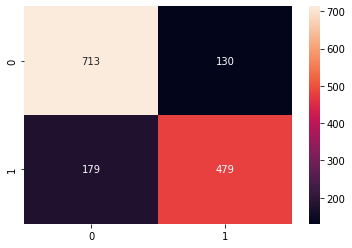

In [97]:
cv=confusion_matrix(y_test,svc_pred)
sns.heatmap(cv,annot=True, fmt='g')

### Submission file:

In [95]:
print(svc_pred)
print(type(svc_pred))

my_array = svc_pred
print(len(my_array))
submission = pd.DataFrame({'Ground Truth':y_test,'Predicted':my_array})
submission['id'] = test['id']
submission = submission[['id','Ground Truth','Predicted']]
submission.to_csv('submission.csv', index=False)
submission

['1' '0' '1' ... '0' '0' '1']
<class 'numpy.ndarray'>
1501


,id,Ground Truth,Predicted
7090,NaN,1,1
1275,4193.0,0,0
5721,NaN,1,1
2308,7710.0,0,0
244,780.0,0,0
...,...,...,...
1785,6028.0,0,0
485,1578.0,0,0
3756,NaN,0,0
1604,5419.0,1,0
